In [10]:
import cupy as cp
import numpy as np

from tqdm import tqdm
import argparse

import matplotlib.pyplot as plt

from kernels.utils import (
    Conv,
    conv_blocks,
    conv_threads,
    Relu,
    relu_blocks,
    relu_threads,
)
from data import load_data

from sklearn.model_selection import train_test_split


def compute_sigma(sample, depth, fix=False):
    coefs, inv_coefs = [1.0], [1.0]

    S = cp.matmul(sample.T, sample).reshape(32, 32, 32, 32)
    Conv(conv_blocks, conv_threads, (S, S))
    T = cp.zeros((32, 32, 32, 32), dtype=cp.float32)
    if not fix:
        T += S

    for i in range(1, depth - 1):
        coef = cp.sqrt(cp.diag(S.reshape(1024, 1024)).reshape(32, 32))
        inv_coef = 1.0 / coef
        coefs.append(coef)
        inv_coefs.append(inv_coef)
        Relu(relu_blocks, relu_threads, (S, T, coef, coef, inv_coef, inv_coef))
        Conv(conv_blocks, conv_threads, (S, S))
        Conv(conv_blocks, conv_threads, (T, T))

    coef = cp.sqrt(cp.diag(S.reshape(1024, 1024)).reshape(32, 32))
    inv_coef = 1.0 / coef
    coefs.append(coef)
    inv_coefs.append(inv_coef)
    Relu(relu_blocks, relu_threads, (S, T, coef, coef, inv_coef, inv_coef))

    if fix:
        T -= S
    return coefs, inv_coefs


def compute_cross_sigma(
    sample1,
    sample2,
    coefs1,
    coefs2,
    inv_coefs1,
    inv_coefs2,
    depth,
    fix=False,
    layer="gap"
):

    S = cp.matmul(sample1.T, sample2).reshape(32, 32, 32, 32)
    Conv(conv_blocks, conv_threads, (S, S))
    T = cp.zeros((32, 32, 32, 32), dtype=cp.float32)
    if not fix:
        T += S

    for i in range(1, depth - 1):
        Relu(
            relu_blocks,
            relu_threads,
            (S, T, coefs1[i], coefs2[i], inv_coefs1[i], inv_coefs2[i]),
        )
        Conv(conv_blocks, conv_threads, (S, S))
        Conv(conv_blocks, conv_threads, (T, T))

    Relu(
        relu_blocks,
        relu_threads,
        (S, T, coefs1[-1], coefs2[-1], inv_coefs1[-1], inv_coefs2[-1]),
    )

    if fix:
        T -= S

    if layer == "gap":
        return cp.mean(T)
    elif layer == "max":
        return cp.max(T)
    else:
        return cp.trace(T.reshape(1024, 1024))

def encode_labels(labels):
    targets = np.ones((len(labels), 10)) * -0.1
    for i, label in enumerate(labels):
        targets[i, label] = 0.9

    return targets

In [13]:
results = {}
times = {}

In [34]:
n_samples = 75

X, Y = load_data()

X = X[:min(n_samples, X.shape[0])]
Y = Y[:min(n_samples, Y.shape[0])]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train = cp.asarray(X_train).reshape(-1, 3, 1024)
X_test = cp.asarray(X_test).reshape(-1, 3, 1024)
Y_train = encode_labels(Y_train)

X_train shape:  (60, 3, 32, 32)
X_test shape:  (15, 3, 32, 32)


In [35]:
from time import perf_counter

In [36]:
for fix in [True]:#, False]:
    for layer in ["gap"]:#, "max", "trace"]:
        for depth in [2, 5, 8, 10, 15, 30]:

            print("Training with depth: ", depth, " and layer: ", layer, " and fix: ", fix)

            start_time = perf_counter()

            train_coefs, train_inv_coefs = [], []
            for sample in tqdm(X_train):
                coefs, inv_coefs = compute_sigma(sample, depth, fix=fix)
                train_coefs.append(coefs)
                train_inv_coefs.append(inv_coefs)

            test_coefs, test_inv_coefs = [], []
            for sample in tqdm(X_test):
                coefs, inv_coefs = compute_sigma(sample, depth, fix=fix)
                test_coefs.append(coefs)
                test_inv_coefs.append(inv_coefs)

            train_kernel = np.zeros((len(X_train), len(X_train)))

            for i, sample1 in tqdm(enumerate(X_train), total=len(X_train)):
                for j, sample2 in enumerate(X_train):
                    train_kernel[i, j] = compute_cross_sigma(
                        sample1, sample2, train_coefs[i], train_coefs[j], train_inv_coefs[i], train_inv_coefs[j], depth, layer=layer
                    )

            test_kernel = np.zeros((len(X_test), len(X_train)))

            for i, sample1 in tqdm(enumerate(X_test), total=len(X_test)):
                for j, sample2 in enumerate(X_train):
                    test_kernel[i, j] = compute_cross_sigma(
                        sample1, sample2, test_coefs[i], train_coefs[j], test_inv_coefs[i], train_inv_coefs[j], depth, layer=layer
                    )

            network = np.linalg.solve(train_kernel, Y_train)

            print("Network shape: ", network.shape)
            print("Train kernel shape: ", train_kernel.shape)
            print("Test kernel shape: ", test_kernel.shape)

            predictions = np.matmul(test_kernel, network)
            predictions = np.argmax(predictions, axis=1)
            accuracy = np.mean(predictions == Y_test)
            print("Accuracy: ", accuracy)

            end_time = perf_counter()

            results[(fix, layer, depth)] = accuracy
            times[(fix, layer, depth)] = end_time - start_time


Training with depth:  2  and layer:  gap  and fix:  True


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.13333333333333333
Training with depth:  5  and layer:  gap  and fix:  True


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.06666666666666667
Training with depth:  8  and layer:  gap  and fix:  True


100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.2
Training with depth:  10  and layer:  gap  and fix:  True


100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.2
Training with depth:  15  and layer:  gap  and fix:  True


100%|██████████| 15/15 [02:41<00:00, 10.79s/it]


Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.2
Training with depth:  30  and layer:  gap  and fix:  True


100%|██████████| 15/15 [01:25<00:00,  5.71s/it]

Network shape:  (60, 10)
Train kernel shape:  (60, 60)
Test kernel shape:  (15, 60)
Accuracy:  0.26666666666666666


In [37]:
times

{(25, True, 'gap', 2): 1.7577968999976292,
 (25, True, 'gap', 5): 6.8257390999933705,
 (25, True, 'gap', 8): 11.881080599996494,
 (25, True, 'gap', 10): 15.321553000001586,
 (25, True, 'gap', 15): 23.851266500001657,
 (25, True, 'gap', 30): 49.6534784000105,
 (50, True, 'gap', 2): 6.651817099991604,
 (50, True, 'gap', 5): 26.860075900010997,
 (50, True, 'gap', 8): 46.479766499993275,
 (50, True, 'gap', 10): 59.87142580001091,
 (50, True, 'gap', 15): 93.20516810000117,
 (50, True, 'gap', 30): 256.9190122,
 (5, True, 'gap', 2): 0.2695285999943735,
 (5, True, 'gap', 5): 0.7046845000004396,
 (5, True, 'gap', 8): 1.0267520000052173,
 (5, True, 'gap', 10): 1.3153746000025421,
 (5, True, 'gap', 15): 1.9986841999925673,
 (5, True, 'gap', 30): 4.4990859999961685,
 (True, 'gap', 2): 23.55295370001113,
 (True, 'gap', 5): 125.78683359999559,
 (True, 'gap', 8): 103.51409019999846,
 (True, 'gap', 10): 482.25620800000615,
 (True, 'gap', 15): 561.0521374999953,
 (True, 'gap', 30): 831.589764999997}

In [38]:
times = {(25, True, 'gap', 2): 1.7577968999976292,
 (25, True, 'gap', 5): 6.8257390999933705,
 (25, True, 'gap', 8): 11.881080599996494,
 (25, True, 'gap', 10): 15.321553000001586,
 (25, True, 'gap', 15): 23.851266500001657,
 (25, True, 'gap', 30): 49.6534784000105,
 (50, True, 'gap', 2): 6.651817099991604,
 (50, True, 'gap', 5): 26.860075900010997,
 (50, True, 'gap', 8): 46.479766499993275,
 (50, True, 'gap', 10): 59.87142580001091,
 (50, True, 'gap', 15): 93.20516810000117,
 (50, True, 'gap', 30): 256.9190122,
 (5, True, 'gap', 2): 0.2695285999943735,
 (5, True, 'gap', 5): 0.7046845000004396,
 (5, True, 'gap', 8): 1.0267520000052173,
 (5, True, 'gap', 10): 1.3153746000025421,
 (5, True, 'gap', 15): 1.9986841999925673,
 (5, True, 'gap', 30): 4.4990859999961685,
 (75, True, 'gap', 2): 23.55295370001113,
 (75, True, 'gap', 5): 125.78683359999559,
 (75, True, 'gap', 8): 103.51409019999846,
 (75, True, 'gap', 10): 482.25620800000615,
 (75, True, 'gap', 15): 561.0521374999953,
 (75, True, 'gap', 30): 831.589764999997}

times

{(25, True, 'gap', 2): 1.7577968999976292,
 (25, True, 'gap', 5): 6.8257390999933705,
 (25, True, 'gap', 8): 11.881080599996494,
 (25, True, 'gap', 10): 15.321553000001586,
 (25, True, 'gap', 15): 23.851266500001657,
 (25, True, 'gap', 30): 49.6534784000105,
 (50, True, 'gap', 2): 6.651817099991604,
 (50, True, 'gap', 5): 26.860075900010997,
 (50, True, 'gap', 8): 46.479766499993275,
 (50, True, 'gap', 10): 59.87142580001091,
 (50, True, 'gap', 15): 93.20516810000117,
 (50, True, 'gap', 30): 256.9190122,
 (5, True, 'gap', 2): 0.2695285999943735,
 (5, True, 'gap', 5): 0.7046845000004396,
 (5, True, 'gap', 8): 1.0267520000052173,
 (5, True, 'gap', 10): 1.3153746000025421,
 (5, True, 'gap', 15): 1.9986841999925673,
 (5, True, 'gap', 30): 4.4990859999961685,
 (75, True, 'gap', 2): 23.55295370001113,
 (75, True, 'gap', 5): 125.78683359999559,
 (75, True, 'gap', 8): 103.51409019999846,
 (75, True, 'gap', 10): 482.25620800000615,
 (75, True, 'gap', 15): 561.0521374999953,
 (75, True, 'gap', 3

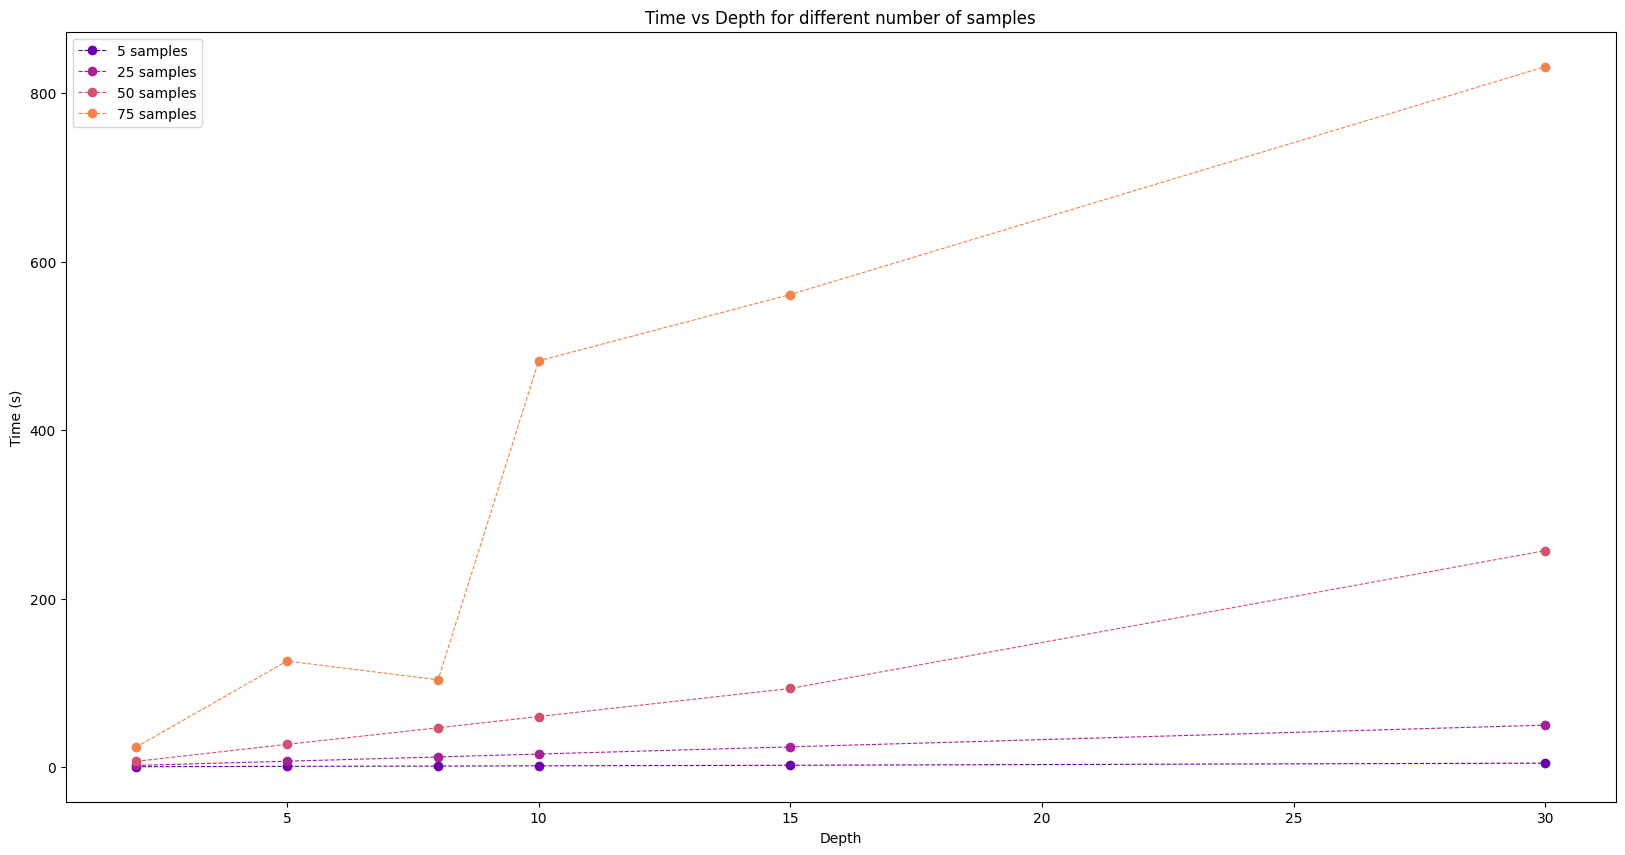

In [47]:
plt.figure(figsize=(20, 10))

colormap = plt.cm.get_cmap("plasma")

for i, n in enumerate([5, 25, 50, 75]):
    for fix in [True]:#, False]:
        for layer in ["gap"]:#, "max", "trace"]:
            times_ = [times[(n, fix, layer, depth)] for depth in [2, 5, 8, 10, 15, 30]]
            # Make color variable in function of layer and fix
            color = colormap(i / 6 + 0.2)
            plt.plot([2, 5, 8, 10, 15, 30], times_, marker="o", linestyle="--", color=color, linewidth=0.8, label=f"{n} samples")

plt.xlabel("Depth")
plt.ylabel("Time (s)")
plt.title("Time vs Depth for different number of samples")
plt.legend()
plt.savefig("time_vs_depth.png", dpi=300, transparent=True)
plt.show()

In [4]:
results = {(True, 'gap', 2): 0.36666666666666664,
 (True, 'gap', 5): 0.3,
 (True, 'gap', 8): 0.26666666666666666,
 (True, 'gap', 10): 0.26666666666666666,
 (True, 'gap', 15): 0.23333333333333334,
 (True, 'gap', 30): 0.43333333333333335,
 (True, 'gap', 50): 0.43333333333333335,
 (True, 'max', 2): 0.06666666666666667,
 (True, 'max', 5): 0.13333333333333333,
 (True, 'max', 8): 0.1,
 (True, 'max', 10): 0.23333333333333334,
 (True, 'max', 15): 0.3,
 (True, 'max', 30): 0.3333333333333333,
 (True, 'max', 50): 0.3333333333333333,
 (True, 'trace', 2): 0.4,
 (True, 'trace', 5): 0.3333333333333333,
 (True, 'trace', 8): 0.4,
 (True, 'trace', 10): 0.4,
 (True, 'trace', 15): 0.4,
 (True, 'trace', 30): 0.36666666666666664,
 (True, 'trace', 50): 0.3333333333333333}

C:\Users\Antoine\AppData\Local\Temp\ipykernel_48324\1966173492.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


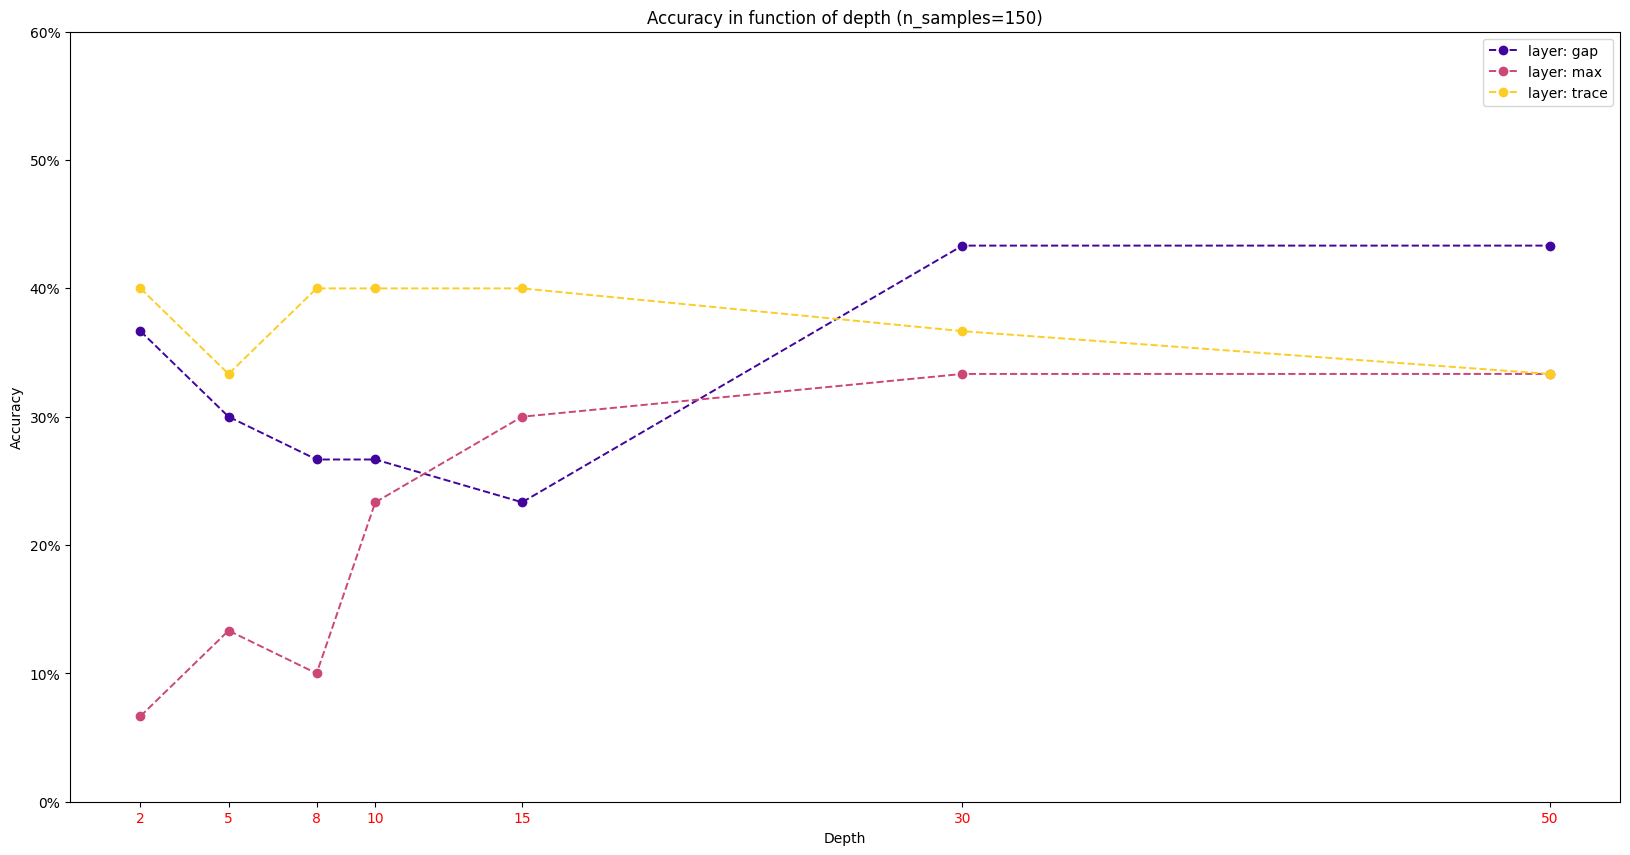

In [8]:
plt.figure(figsize=(20, 10))

colormap = plt.cm.get_cmap("plasma")

for fix in [True]:
    for layer in ["gap", "max", "trace"]:
        accuracies = [results[(fix, layer, depth)] for depth in [2, 5, 8, 10, 15, 30, 50]]
        # Make color variable in function of layer and fix
        if layer == "gap":
            color = colormap(0.1)
        elif layer == "max":
            color = colormap(0.5)
        else:
            color = colormap(0.9)
        plt.plot([2, 5, 8, 10, 15, 30, 50], accuracies, label=f"layer: {layer}", marker="o", linestyle="--", linewidth=1.4, color=color)

ylim = 0.6
plt.ylim(0, ylim)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.xlabel("Depth")
plt.ylabel("Accuracy")
# Add special ticks for depth values [2, 5, 8, 10, 15, 30, 50] with color red
plt.xticks([2, 5, 8, 10, 15, 30, 50], color="red")
plt.title("Accuracy in function of depth (n_samples=150)")
plt.legend()
plt.savefig("accuracy_depth_150_more.png", dpi=300, transparent=True)
plt.show()

In [35]:
acc_gap_fix = [0.25, 0.3, 0.3, 0.3, 0.25, 0.35, 0.3]
acc_vanilla_fix = [0.35, 0.3, 0.25, 0.25, 0.25, 0.3, 0.25]
acc_max_fix = [0.1, 0.15, 0.15, 0.15, 0.25, 0.2, 0.25]

acc_gap_unfix = [0.25, 0.3, 0.3, 0.3, 0.25, 0.35, 0.3]
acc_vanilla_unfix = [0.35, 0.3, 0.25, 0.25, 0.25, 0.3, 0.25]

C:\Users\Antoine\AppData\Local\Temp\ipykernel_74332\3229755676.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


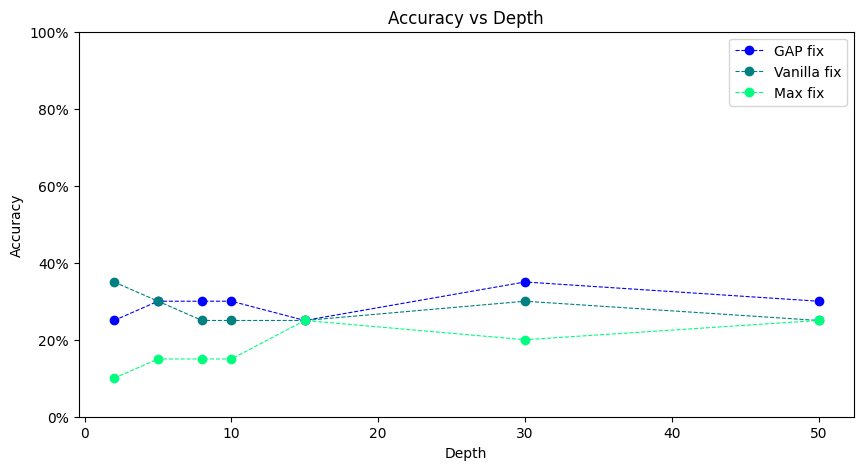

In [37]:
plt.figure(figsize=(10, 5))

depths = [2, 5, 8, 10, 15]
depths_plus = [2, 5, 8, 10, 15, 30, 50]

plt.plot(depths_plus, acc_gap_fix, marker="o", linestyle="--", color="b", label="GAP fix", linewidth=0.8)
plt.plot(depths_plus, acc_vanilla_fix, marker="o", linestyle="--", color="teal", label="Vanilla fix", linewidth=0.8)
plt.plot(depths_plus, acc_max_fix, marker="o", linestyle="--", color="springgreen", label="Max fix", linewidth=0.8)


# plt.plot(depths_plus, acc_gap_unfix, marker="o", linestyle="-", color="b", label="GAP unfix", linewidth=0.8)
# plt.plot(depths_plus, acc_vanilla_unfix, marker="o", linestyle="-", color="teal", label="Vanilla unfix", linewidth=0.8)
# plt.plot(depths_plus, acc_max_fix, marker="o", linestyle="--", color="g", label="Max fix", linewidth=0.8)

plt.xlabel("Depth")
plt.ylim(0, 1)
# Set the y to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.ylabel("Accuracy")
plt.title("Accuracy vs Depth")
plt.legend()
plt.show()